<p>
    We can start the next iteration by using techniques in improving submission category 
    
    The end goal will be to combine different algorithms. We have already created 2: A logistical regression and random trees model. 
    First we will attempt to improve the logistical regression model by training it by doing better cross validation splits or changing the scoring method(log(loss)) 
    In addtion we will add combine the age and gender category to create a young and old male/female to see if this new category will improve our system. We can try extracting crew status(included into title).
   
    After reaching a good point we will combine the 2 to see if we can improve our score
</p>

<p>We can start off by prepping our data for both test and train. </p>

In [2]:
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import thinkstats2
import thinkplot
import re
import numpy as np
%matplotlib inline
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

titanic = pd.read_csv("train.csv")

# Clean and Prep train Data
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2
#add Title
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))
# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v
# Add in the title column.
titanic["Title"] = titles

titanic_test = pd.read_csv("test.csv")

#Clean and Prep test data
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2
#add title 
# Add Title to the test data
titles = titanic_test["Name"].apply(get_title)
# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
# Add in the title column.
titanic_test["Title"] = titles

titanic.describe()

#method taken from datquest
#accuracy methods
def calculate_accuracy(predictions_data):
    # Map predictions to outcomes (only possible outcomes are 1 and 0)
    predictions_data[predictions_data > .5] = 1
    predictions_data[predictions_data <=.5] = 0
    accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
    print accuracy


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64


/home/wilson/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<p> We will be seeing if we can improve our model by combining and reclassifying features. From explorations we notice that Age and Gender are related but the relationship is hard to capture with only those two so we can combine and split into 4 categories: young male, young female, adult male, adult female.</p>


In [3]:
#create the 4 new categories
# 0 = false
# 1 = true
titanic["Young_M"] = titanic["Age"]
titanic["Adult_M"] = titanic["Age"] 
titanic["Young_F"] = titanic["Age"]
titanic["Adult_F"] = titanic["Age"] 
titanic.loc[titanic.Young_M.notnull(), 'Young_M'] = 0
titanic.loc[titanic.Adult_M.notnull(), 'Adult_M'] = 0
titanic.loc[titanic.Young_F.notnull(), 'Young_F'] = 0
titanic.loc[titanic.Adult_F.notnull(), 'Adult_F'] = 0
titanic.loc[(titanic.Age < 18) & (titanic.Sex == 0), 'Young_M'] = 1
titanic.loc[(titanic.Age >= 18) & (titanic.Sex == 0), 'Adult_M'] = 1
titanic.loc[(titanic.Age < 18) & (titanic.Sex == 1), 'Young_F'] = 1
titanic.loc[(titanic.Age >= 18) & (titanic.Sex == 1), 'Adult_F'] = 1
#sanity check that there are only 1 per row for each of the categories
print titanic

#now we do the same to titanic test
titanic_test["Young_M"] = titanic_test["Age"]
titanic_test["Adult_M"] = titanic_test["Age"] 
titanic_test["Young_F"] = titanic_test["Age"]
titanic_test["Adult_F"] = titanic_test["Age"] 
titanic_test.loc[titanic_test.Young_M.notnull(), 'Young_M'] = 0
titanic_test.loc[titanic_test.Adult_M.notnull(), 'Adult_M'] = 0
titanic_test.loc[titanic_test.Young_F.notnull(), 'Young_F'] = 0
titanic_test.loc[titanic_test.Adult_F.notnull(), 'Adult_F'] = 0
titanic_test.loc[(titanic_test.Age < 18) & (titanic_test.Sex == 0), 'Young_M'] = 1
titanic_test.loc[(titanic_test.Age >= 18) & (titanic_test.Sex == 0), 'Adult_M'] = 1
titanic_test.loc[(titanic_test.Age < 18) & (titanic_test.Sex == 1), 'Young_F'] = 1
titanic_test.loc[(titanic_test.Age >= 18) & (titanic_test.Sex == 1), 'Adult_F'] = 1
#sanity check that there are only 1 per row for each of the categories
print titanic_test


     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
5              6         0       3   
6              7         0       1   
7              8         0       3   
8              9         1       3   
9             10         1       2   
10            11         1       3   
11            12         1       1   
12            13         0       3   
13            14         0       3   
14            15         0       3   
15            16         1       2   
16            17         0       3   
17            18         1       2   
18            19         0       3   
19            20         1       3   
20            21         0       2   
21            22         1       2   
22            23         1       3   
23            24         1       1   
24            25         0       3   
25          

<p> Now we can try out these new categories and remove the old categories to see if it improves either of our models! </p>

In [4]:
#Trying out Logistical Regression Model 
print titanic.describe()
predictors = ["Pclass","SibSp","Parch","Fare","Embarked","Title","Young_M","Adult_M","Young_F","Adult_F"]
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print scores.mean()

predictors = ["Pclass","Age", "Sex", "SibSp","Parch","Fare","Embarked","Title"]
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print scores.mean()

predictors = ["Pclass","Age", "Sex", "SibSp","Parch","Fare","Embarked","Title","Young_M","Adult_M","Young_F","Adult_F"]
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print scores.mean()

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare     Young_M     Adult_M     Young_F     Adult_F  
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000  
mean     0.381594   32.204208    0.065095    0.582492    0.061728    0.290685  
std      0.806057   49.693429    0.246833    0.493425    0.240797    0.454333  
min      0.000000    0.000000    0.000000    0.00

<p> 
    From the three test we see that adding the 4 categories to the logistical regression improves the model the most.
    Now we will try what it does to our previous version of the trees
</p>

0.810325476992


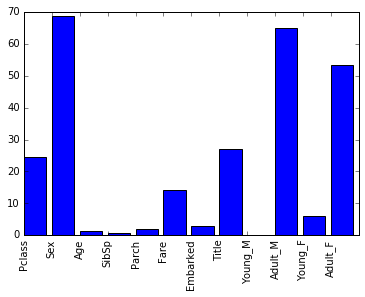

In [5]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title","Young_M","Adult_M","Young_F","Adult_F"]

alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print(scores.mean())
#method taken from datquest
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


<p> From the histogram we can see the most effective trees to use. Now we will try different permutations of the best categories to determine the best tree algorithm(we found the optimal amount of categories to be 5 from before so we'll start from there)</p>

In [6]:
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('5 categories old ' + str(scores.mean()))

predictors = ["Pclass", "Sex", "Adult_F", "Adult_M", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('5 categories with new max 5 ' + str(scores.mean()))

predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title","Adult_M"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('6 categories ' + str(scores.mean()))

predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title" ,"Adult_M","Adult_F"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('7 categories ' + str(scores.mean()))

5 categories old 0.82379349046
5 categories with new max 5 0.781144781145
6 categories 0.826038159371
7 categories 0.818181818182


<p> from these results we see that adding these new categories on top of the already existing sex seems to not do much. However removing Fare and Embarked made the score significantly worse which probably has something to do with way trees work.

Next we can try out taking out sex and using combinations of the 4 new categories in its stead
</p>

In [7]:
#new test
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title", "Young_F", "Adult_M","Young_M","Adult_F"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=18, min_samples_leaf= 9)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('All categories ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Embarked", "Adult_F", "Adult_M", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('5 categories: class,embarked,adult_f,adult_m,title ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=12, min_samples_leaf= 6)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('6 categories: class,embarked,fare,adult_f,adult_m,title ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('6 categories: class,embarked,fare,adult_f,adult_m,title ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title" ,"Adult_M","Adult_F","Sex"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=16, min_samples_leaf= 8)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('7 categories: class,embarked,fare,adult_f,adult_m,title,sex ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title" ,"Adult_M","Adult_F","Young_F"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=16, min_samples_leaf= 8)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('6 categories: class,embarked,fare,adult_f,adult_m,title ' + str(scores.mean()))

All categories 0.82379349046
5 categories: class,embarked,adult_f,adult_m,title 0.812570145903
6 categories: class,embarked,fare,adult_f,adult_m,title 0.828282828283
6 categories: class,embarked,fare,adult_f,adult_m,title 0.814814814815
7 categories: class,embarked,fare,adult_f,adult_m,title,sex 0.818181818182
6 categories: class,embarked,fare,adult_f,adult_m,title 0.820426487093


<p> 
From this series of test we have a noticable difference in the tree model using 6 categories: Pclass, Embarked, Fare, Adult_F, Adult_M, and title. An interesting parameter to vary is the min_samples_split and min_samples_leaf as it makes a noticable difference in the score. So we can try to maximize our best tree attempt.
</p>

In [8]:
#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('10,5 ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M","Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=12, min_samples_leaf= 6)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('12,6 ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M","Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('10,4 ' + str(scores.mean()))

10,5 0.829405162738
12,6 0.828282828283
10,4 0.83164983165


In [9]:
#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M","Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split= 14, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('10, 3 ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M","Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split= 17, min_samples_leaf= 4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('10, 3 ' + str(scores.mean()))

10, 3 0.836139169473
10, 3 0.833894500561


<p>
    Because the top scores are close to each other we will make a submission for each and see what kaggle score we get! In addition we will submit the logistical regression model for fun to see the difference!
</p>

In [10]:
predictors = ["Pclass","Age", "Sex", "SibSp","Parch","Fare","Embarked","Title","Young_M","Adult_M","Young_F","Adult_F"]

alg = LogisticRegression(random_state=1)

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v4.csv", index = False)

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M","Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split= 14, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('10, 3 ' + str(scores.mean()))

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v4-1.csv", index = False)

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M","Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split= 17, min_samples_leaf= 4)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('10, 3 ' + str(scores.mean()))

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v4-2.csv", index = False)

10, 3 0.836139169473
10, 3 0.833894500561


<p>
   Old Best Score: 0.78469
   Our Improved Logistical Model Score: 0.77033
   Our Best Random Tree Score: 0.78469
   Our 2nd Best Random Tree Score: 0.78947
   From our results we can see that manipulating the random tree parameters and adding new categories can help the score but probably only by a small amount unless the new parameters were something not covered by the tree before. Unfortunately Logistical Regression was not able to improve enough. 
</p>

<p> 
Next we can try using gradient boosting classifier on our most promising category combinations to see if we can get a good score out of it </p> 
<p>

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

#new test
predictors = ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M", "Title"]

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print ('Gradient 6 categories: class,embarked,fare,adult_f,adult_m,title ' + str(scores.mean()))

#new test
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title","Adult_M"]

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print ('Gradient 6 categories: class,sex,embarked,fare,adult_m,title ' + str(scores.mean()))


Gradient 6 categories: class,embarked,fare,adult_f,adult_m,title 0.82379349046
Gradient 6 categories: class,sex,embarked,fare,adult_m,title 0.81593714927


<p>
    Interestingly the two best Gradient 6 categories: class,embarked,fare,adult_f,adult_m,title and Gradient 7 categories: class,sex,embarked,fare,adult_f,adult_m,title are still below the previous best tree technique. 
     
   In an attempt to improve our Gradient Boosting Classifier which uses the errors from previous models we can try to use all of our features and more to increase the amount of weak learners and hopefully improve the algorithm.    
</p>

In [18]:
#new test
print titanic.describe() 

predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title","Adult_M","Adult_F","Young_M","Young_F","Age"]

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print ('Gradient with all valid categories: ' + str(scores.mean()))


       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare     Young_M     Adult_M     Young_F     Adult_F  
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000  
mean     0.381594   32.204208    0.065095    0.582492    0.061728    0.290685  
std      0.806057   49.693429    0.246833    0.493425    0.240797    0.454333  
min      0.000000    0.000000    0.000000    0.00

<p>That improved so let us try to add some more categories: 
Let's try to make sense of the cabin category, and create a new category of family size and family id to make use of the categories we weren't using
</p>

In [41]:
import operator
#method taken from datquest

# Generating a familysize column based on SibSp and Parch
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

#add family to training data 
family_ids = titanic.apply(get_family_id, axis=1)
family_ids[titanic["FamilySize"] < 3] = -1
titanic["FamilyId"] = family_ids

#do the same for test_data
family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids

#mapping nan and filled in values for cabin to 0.5 or 1
titanic.loc[titanic.Cabin.isnull() == False, 'Cabin'] = 0.5
titanic.loc[titanic.Cabin.isnull() == True, 'Cabin'] = 1
titanic_test.loc[titanic_test.Cabin.isnull() == False, 'Cabin'] = 0.5
titanic_test.loc[titanic_test.Cabin.isnull() == True, 'Cabin'] = 1

predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title","Adult_M","Adult_F","Young_M","Young_F","Age","FamilySize","FamilyId","Cabin"]

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print ('Gradient with new valid categories: ' + str(scores.mean()))\



Gradient with new valid categories: 0.822671156004


<p>
Adding the two categories improved the model above some but made it worse than the gradient with 5. This is probably due to misleading predictors messing the algorithm up. Next we can try taking out all the categories that are based off each other and seeing if that improves it and if so make a submission!
</p>

In [47]:
predictors = ["Pclass", "Fare", "Embarked", "Title","Adult_M","Adult_F","FamilySize","FamilyId"]

alg = GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print ('Gradient: ' + str(scores.mean()))

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v5-1.csv", index = False)

Gradient: 0.824915824916


<p>
        Wooo the gradient model improved the model(Kaggle: 0.79904) - despite having a significantly worse score than the tree versions which seems to indicate the other models were overfitting. We can try to use these new categories in our Rtrees and logistical to improve the score.
</p>

In [51]:
predictors = ["Pclass", "Sex", "Fare", "Embarked", "Title","FamilySize","FamilyId"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=10, min_samples_leaf= 5)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv =3)

print('5 categories old ' + str(scores.mean()))

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v5-3.csv", index = False)

predictors = ["Pclass","Age", "Sex", "SibSp","Parch","Fare","Embarked","Title","Young_M","Adult_M","Young_F","Adult_F","FamilySize","FamilyId"]
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print scores.mean()

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v5-4.csv", index = False)

5 categories old 0.818181818182
0.812570145903


<p>
The previous combination creates a Kaggle Score of 0.78469 which was still worse than our best rtree model which seems to indicate that the categories are not enough. Adding the new categories improved the logistical regression score to : 0.7703.
Now we can combine the best gradient boosting with best logistic regression and the best tree with best logistic regression to see if our score improves.
</p>

In [53]:
from sklearn.cross_validation import KFold
# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Fare", "Embarked", "Title","Adult_M","Adult_F","FamilySize","FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass","Age", "Sex", "SibSp","Parch","Fare","Embarked","Title","FamilySize","FamilyId","Young_M","Adult_M","Young_F","Adult_F"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v6-1.csv", index = False)

#Random Trees and Logistical Regression
algorithms = [
    [RandomForestClassifier(random_state=1, n_estimators=25, min_samples_split=10, min_samples_leaf= 5), ["Pclass", "Embarked", "Fare", "Adult_F", "Adult_M", "Title"]],
    [LogisticRegression(random_state=1), ["Pclass","Age", "Sex", "SibSp","Parch","Fare","Embarked","FamilySize","FamilyId","Title","Young_M","Adult_M","Young_F","Adult_F"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

alg.fit(titanic[predictors], titanic["Survived"])

predictions = alg.predict(titanic_test[predictors])

submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle_v6-2.csv", index = False)

/home/wilson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wilson/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:81: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


0.820426487093
0.819304152637


<p>
        Unfortunately the difference in models is too much between the tree and logistical to benefit from the combination. The accuracy is very low for both combinations compared to the tree alone and even variations in the set will probably not make up the difference. But we can try the second model out to see what kaggle score we get.
        Kaggle for Gradient and Logistical: 0.773 , which went down probably due to the logistical regression model being too low
        Kaggle for Tree and Logistical: 0.77 which also went down probably due to the logistical regression model being too low
</p>

<p>
    In ending notes we see that the different models all have different results due to the available information and that adding parameters/features only works if the features are meaningful. In addition the ability of gradient was able to use the weak models benefitted from using the weaker data and features. Unfortunately we weren't able to improve the logistical regression model enough to have it assists the gradient algorithm. Final best score: 0.79904
</p>